In [1]:
from geometry import *

In [2]:
@dataclass
class Shape:
    coords: Optional[List[Tuple[float, float]]] = field(default_factory=list)
    data: Optional[dict] = field(default_factory=dict)

    def to_gdf(self) -> gpd.GeoDataFrame:
        """Convert shape to a GeoDataFrame."""
        gdf_dict = self.data or {}  # Use data if provided
        gdf_dict["geometry"] = self.geometry
        return gpd.GeoDataFrame([gdf_dict])
    
    @classmethod
    def random(cls, shape_type: str = None, bounds: Tuple[int, int] = (0, 100)) -> 'Shape':
        """Generate a random shape (Point, LineString, or Polygon)."""
        shape_type = shape_type or random.choice(["point", "line", "polygon"])  # Choose randomly if not provided
        
        if shape_type == "point":
            return Point(coords=(random.randint(*bounds), random.randint(*bounds)))

        elif shape_type == "line":
            num_points = random.randint(2, 5)  # Random number of line points
            coords = [(random.randint(*bounds), random.randint(*bounds)) for _ in range(num_points)]
            return Line(coords=coords)

        elif shape_type == "polygon":
            num_points = random.randint(3, 6)  # Random polygon (at least 3 points)
            points = []
            for _ in range(num_points):
                point = Point(coords=(random.randint(*bounds), random.randint(*bounds)))
                points.append(point.coords)

            coords = list(MultiPoint(points=points).geometry.convex_hull.exterior.coords)  # Create a convex hull to form a polygon

            return Polygon(coords=coords)  # Return the convex hull as a polygon

        else:
            raise ValueError(f"Unknown shape type: {shape_type}")
        
        
@dataclass
class Polygon(Shape):
    origin: Optional[Tuple[float, float]] = field(default=None)
    size: Optional[Tuple[float, float]] = field(default=None)
    interior : Optional[List[List[float]]] = field(default=None)  # For holes in the polygon
    geometry: object = field(init=False)
    
    def __post_init__(self):
        if self.origin is not None and self.size is not None:
            self.coords = [
                self.origin,
                (self.origin[0] + self.size[0], self.origin[1]),
                (self.origin[0] + self.size[0], self.origin[1] + self.size[1]),
                (self.origin[0], self.origin[1] + self.size[1]),
            ]
        elif self.coords is not None:
            pass  # Use given coords
        else:
            raise ValueError("Must provide either `origin` and `size`, or `coords`.")
        
        holes = self.interior or []
        self.geometry = ShapelyPolygon(self.coords, holes=holes)

    def split_grid(self, rows: int, cols: int) -> List['Polygon']:
        """Splits the polygon into a grid of `rows x cols` smaller polygons."""
        if self.size is None or self.origin is None:
            raise ValueError("Grid splitting requires `origin` and `size`.")

        width, height = self.size[0] / cols, self.size[1] / rows
        sub_polygons = []

        for i in range(rows):
            for j in range(cols):
                sub_origin = (self.origin[0] + j * width, self.origin[1] + i * height)
                sub_polygons.append(Polygon(origin=sub_origin, size=(width, height)))

        return sub_polygons


@dataclass
class MultiPolygon(Shape):
    polygons: List[Union['Polygon', List[List[float]]]] = field(default_factory=list)
    geometry: object = field(init=False)
    

    def __post_init__(self):
        """Convert input into a valid Shapely MultiPolygon."""
        processed_polygons = []
        
        for item in self.polygons:
            if isinstance(item, Polygon):  # If a Polygon instance, use its geometry
                processed_polygons.append(item.geometry)
            elif isinstance(item, list):  # If a list of coordinates, create a Polygon
                processed_polygons.append(ShapelyPolygon(item))
            else:
                raise TypeError("MultiPolygon must be initialized with Polygon instances or coordinate lists.")

        self.geometry = ShapelyMultiPolygon(processed_polygons)
        geoms = list(self.geometry.geoms)  # Store the coordinates of the MultiPolygon for potential use
        self.coords = [list(geom.exterior.coords) for geom in geoms]  # Store the coordinates of the MultiPolygon for potential use



@dataclass
class Line(Shape):
    geometry: object = field(init=False)
    def __post_init__(self):
        if self.coords is None:
            raise ValueError("Must provide `coords`.")
        
        self.geometry = ShapelyLineString(self.coords)

@dataclass
class MultiLine(Shape):
    lines: List[Union['Line', List[Tuple[float, float]]]] = field(default_factory=list)
    geometry: object = field(init=False)
    

    def __post_init__(self):
        """Convert input into a valid Shapely MultiLineString."""
        processed_lines = []
        
        for item in self.lines:
            if isinstance(item, Line):
                processed_lines.append(item.geometry)
            elif isinstance(item, list):
                processed_lines.append(ShapelyLineString(item))
            else:
                raise TypeError("MultiLine must be initialized with Line instances or coordinate lists.")
            
        self.geometry = ShapelyMultiLineString(processed_lines)
        geoms = list(self.geometry.geoms)  # Store the coordinates of the MultiLineString for potential use
        self.coords = [list(geom.coords) for geom in geoms]  # Store the coordinates of the MultiLineString for potential use

@dataclass
class Point(Shape):
    geometry: object = field(init=False)
    def __post_init__(self):
        if self.coords is None:
            raise ValueError("Must provide `coords`.")
        
        self.geometry = ShapelyPoint(self.coords)

@dataclass
class MultiPoint(Shape):
    points: List[Union['Point', Tuple[float, float]]] = field(default_factory=list)
    geometry: object = field(init=False)
    

    def __post_init__(self):
        """Convert input into a valid Shapely MultiPoint."""
        processed_points = []
        
        for item in self.points:
            if isinstance(item, Point):
                processed_points.append(item.geometry)
            elif isinstance(item, tuple):
                processed_points.append(ShapelyPoint(item))
            else:
                raise TypeError("MultiPoint must be initialized with Point instances or coordinate tuples.")
            
        self.geometry = ShapelyMultiPoint(processed_points)
        geoms = list(self.geometry.geoms)
        self.coords = [list(geom.coords) for geom in geoms]



In [3]:
from dataclasses import dataclass, field
from typing import List, Tuple, Optional, Dict, Any, Union, Callable, Set, TypeVar, Generic, Iterable, Iterator, Sequence, Mapping
from shapely.geometry import (
    Polygon as ShapelyPolygon, 
    Point as ShapelyPoint, 
    LineString as ShapelyLineString, 
    MultiLineString as ShapelyMultiLineString,
    MultiPoint as ShapelyMultiPoint,
    MultiPolygon as ShapelyMultiPolygon
)
import geopandas as gpd
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt


In [41]:
pol1ygon = Polygon(origin=(0, 0), size=(10, 10), data={"name": "Square"})
p1_gdf = pol1ygon.to_gdf()
p1_gdf

,name,geometry
0,Square,"POLYGON ((0 0, 10 0, 10 10, 0 10, 0 0))"


In [43]:
p1_gdf.geometry.to_list()

[<POLYGON ((0 0, 10 0, 10 10, 0 10, 0 0))>]

In [ ]:
from dataclasses import dataclass, field
from typing import List, Dict, Any, Optional, Tuple, Union
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
from geometry import Shape

@dataclass
class Map:
    # Layers: each layer holds a list of items (each item is a dict with keys: 'shape', 'label', and 'label_kwargs')
    layers: Dict[str, Dict[str, Any]] = field(
        default_factory=dict
    )
    title: str = "My Map"

    def add_gdf(
            self,
            gdf: gpd.GeoDataFrame,
            layer: str = "default",
            style: Optional[Dict[str, Any]] = None,
            label_col: Optional[str] = None,
            label_kwargs: Optional[Dict[str, Any]] = None
    ) -> None:
        """
        Add a GeoDataFrame to a specific layer.
        
        - The `style` dict holds plotting style options.
        - The `label` can be a boolean or a string:
            - If True, it expects a "label" column in gdf.
            - If a string, that string is used as a column name in gdf.
        - The `label_kwargs` dict allows you to control the text appearance (e.g. color, alignment, fontsize).
        """
        if layer not in self.layers:
            self.layers[layer] = {"shapes": [], "style": style or {}}
        self.layers[layer]["shapes"].append({
            "shape": gdf,
            "label": label_col,
            "label_kwargs": label_kwargs or {}
        })
        if style:
            self.layers[layer]["style"].update(style)

            
    def add_shape(
        self, 
        shape: Shape, 
        layer: str = "default", 
        style: Optional[Dict[str, Any]] = None,
        label_col: Optional[str] = None,
        label_kwargs: Optional[Dict[str, Any]] = None
    ) -> None:
        """
        Add a shape to a specific layer.
        
        - The `style` dict holds plotting style options.
        - The `label` can be a boolean or a string:
            - If True, it expects a "label" key in shape.data.
            - If a string, that string is used as a key in shape.data.
        - The `label_kwargs` dict allows you to control the text appearance (e.g. color, alignment, fontsize).
        """
        if layer not in self.layers:
            self.layers[layer] = {"shapes": [], "style": style or {}}
        self.layers[layer]["shapes"].append({
            "shape": shape,
            "label": label_col,
            "label_kwargs": label_kwargs or {}
        })
        if style:
            self.layers[layer]["style"].update(style)
    
    def plot(self, figsize: Tuple[int, int]=(10, 10)) -> None:
        """
        Plot all layers using matplotlib.
        
        - The legend always shows the layer names.
        - If a shape has a label, a text annotation is drawn at the shape's centroid.
          The appearance of this label is controlled by default settings that can be overridden via label_kwargs.
        """
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot each shape and add text annotations if a label is provided.
        for layer_name, info in self.layers.items():
            for item in info["shapes"]:
                shape = item["shape"]
                label_option = item["label"]
                gdf = shape.to_gdf()
                plot_kwargs = dict(info["style"])  # copy style options for plotting
                # Plot the shape.
                gdf.plot(ax=ax, **plot_kwargs)
                
                # If a label is provided, add a text annotation using label_kwargs.
                if isinstance(label_option, str):
                    text_label = shape.data.get(label_option, label_option)
                else:
                    text_label = None

                if text_label:
                    # Get the centroid of the shape for the label's position.
                    centroid = shape.geometry.centroid
                    # Default label styling options.
                    default_label_kwargs = {
                        "horizontalalignment": "center",
                        "verticalalignment": "center",
                        "fontsize": 10,
                        "color": "black",
                        "weight": "bold"
                    }
                    # Update defaults with any provided label_kwargs.
                    default_label_kwargs.update(item["label_kwargs"])
                    ax.text(centroid.x, centroid.y, text_label, **default_label_kwargs)
        
        # Create legend proxies for each layer based on the layer's style.
        legend_proxies = []
        for layer_name, info in self.layers.items():
            style = info["style"]
            # Use specified color or fallback default.
            color = style.get("color", style.get("facecolor", "blue"))
            geom = info["shapes"][0]["shape"].geometry  # Get the geometry of the first shape in the layer for legend proxy
            if hasattr(geom, 'geom_type'):
                if geom.geom_type in ["Polygon", "MultiPolygon"]:
                    # Use a Patch proxy for polygons.
                    proxy = Patch(
                        facecolor=color,
                        edgecolor=style.get("edgecolor", "black"),
                        label=layer_name
                    )
                elif geom.geom_type in ["LineString", "MultiLineString"]:
                    
                    # Use a Line2D proxy for lines.
                    proxy = mlines.Line2D([], [], color=color, label=layer_name)

                elif geom.geom_type in ["Point", "MultiPoint"]:
                    # Use a Patch proxy for points (as small circles).
                    proxy = mlines.Line2D([], [], marker='o', color='w', label=layer_name, markerfacecolor=color)
                else: # default
                    proxy = Patch(
                        facecolor=color,
                        edgecolor=style.get("edgecolor", "black"),
                        label=layer_name
                    )
            else:
                # Fallback for non-standard geometries.
                proxy = Patch(
                    facecolor=color,
                    edgecolor=style.get("edgecolor", "black"),
                    label=layer_name
                )
            legend_proxies.append(proxy)
        
        ax.legend(handles=legend_proxies, loc='upper left')
        ax.set_title(self.title)
        plt.show()




In [49]:
poly = Polygon(origin=(0, 0), size=(10, 10), data={"FIPS": "08031", "NAME": "place1"})
point = Point(coords=(3, 5), data={"FIPS": "08031", "NAME": "fs1"})

m = Map()
m.add_shape(
    poly, 
    layer='Place', 
    style={"facecolor": "blue", "edgecolor": 'red', "alpha": 0.5}, 
    label_col='FIPS', 
    label_kwargs={"color": "black", "fontsize": 12, "horizontalalignment": "left"}
)
m.add_shape(
    point, 
    layer='FireStations', 
    style={"color": "red", "edgecolor": "black"}, 
    label_col='NAME', 
    label_kwargs={"color": "green", "fontsize": 10, "horizontalalignment": "right"}
    )
m.layers

{'Place': {'shapes': [{'shape': Polygon(coords=[(0, 0), (10, 0), (10, 10), (0, 10)], data={'FIPS': '08031', 'NAME': 'place1'}, origin=(0, 0), size=(10, 10), interior=None, geometry=<POLYGON ((0 0, 10 0, 10 10, 0 10, 0 0))>),
    'label': 'FIPS',
    'label_kwargs': {'color': 'black',
     'fontsize': 12,
     'horizontalalignment': 'left'}}],
  'style': {'facecolor': 'blue', 'edgecolor': 'red', 'alpha': 0.5}},
 'FireStations': {'shapes': [{'shape': Point(coords=(3, 5), data={'FIPS': '08031', 'NAME': 'fs1'}, geometry=<POINT (3 5)>),
    'label': 'NAME',
    'label_kwargs': {'color': 'green',
     'fontsize': 10,
     'horizontalalignment': 'right'}}],
  'style': {'color': 'red', 'edgecolor': 'black'}}}

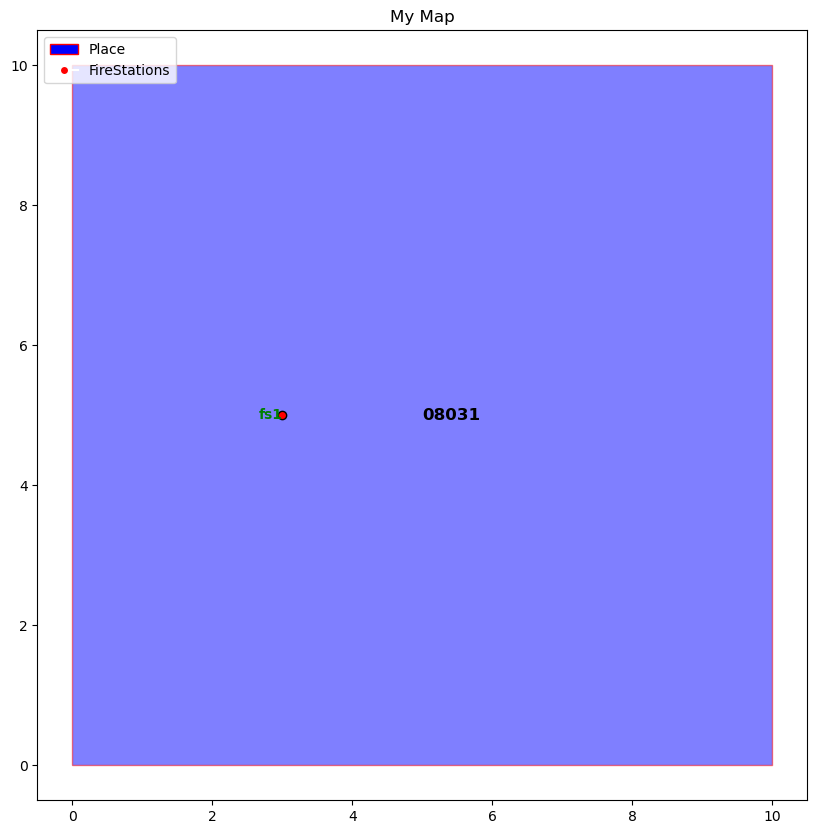

In [50]:
m.plot()

In [ ]:
# Example usage:
if __name__ == "__main__":
    from geometry import Point, Polygon

    # Create a Map instance.
    my_map = Map(title="Layered Map with Custom Labels")
    
    # Add a point to the "points" layer, with its label taken from shape.data["label"],
    # and customize label appearance.
    point = Point(coords=(10, 10))
    point.data["label"] = "Center Point"
    my_map.add_shape(point, layer="points", style={"color": "red"}, label=True,
                     label_kwargs={"color": "darkred", "fontsize": 12})
    
    # Add a polygon to the "polygons" layer with a custom label key.
    poly = Polygon(origin=(20, 20), size=(15, 10))
    poly.data["name"] = "Test Polygon"
    my_map.add_shape(poly, layer="polygons",
                     style={"facecolor": "green", "edgecolor": "black", "alpha": 0.5},
                     label="name", label_kwargs={"color": "white", "weight": "normal"})
    
    # Plot the map.
    my_map.plot()

In [143]:
# create a polygon with interior coords
poly = Polygon(origin=(0, 0), size=(10, 10), interior=[[(2, 2), (2, 4), (4, 4), (4, 2)], [(6, 6), (6, 8), (8, 8), (8, 6)]])
print(poly.geometry)

POLYGON ((0 0, 10 0, 10 10, 0 10, 0 0), (2 2, 2 4, 4 4, 4 2, 2 2), (6 6, 6 8, 8 8, 8 6, 6 6))


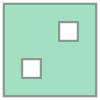

In [144]:
poly.geometry

In [134]:
mp = MultiLine(lines=[[(0,0), (1,1)], [(2,2), (3,3)]])
mp.coords

[[(0.0, 0.0), (1.0, 1.0)], [(2.0, 2.0), (3.0, 3.0)]]

In [127]:
coords = []
for geom in geoms:
    coords.append(list(geom.coords))

In [128]:
coords

[[(0.0, 0.0), (1.0, 1.0)], [(2.0, 2.0), (3.0, 3.0)]]

In [102]:
gdf = pd.concat([shape.to_gdf() for shape in geoms], ignore_index=True)
gdf

,geometry
0,POINT (73 42)
1,POINT (52 96)
2,POINT (33 0)
3,POINT (61 89)
4,POINT (66 87)
5,POINT (3 72)
6,POINT (11 38)
7,POINT (30 38)
8,POINT (94 38)
9,POINT (21 84)


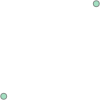

In [77]:
mp = MultiPoint(points=[Point(coords=[(1,1)]), Point(coords=[3,3])], data={"name": "multiA"})
mp.geometry

In [52]:
ml = MultiLine(lines=[Line(coords=[(0, 0), (1, 1)]), Line(coords=[(4,4), (0, 8)])])
ml

MultiLine(coords=[], data={}, lines=[Line(coords=[(0, 0), (1, 1)], data={}, geometry=<LINESTRING (0 0, 1 1)>), Line(coords=[(4, 4), (0, 8)], data={}, geometry=<LINESTRING (4 4, 0 8)>)], geometry=<MULTILINESTRING ((0 0, 1 1), (4 4, 0 8))>)

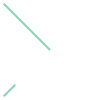

In [53]:
ml.geometry

In [46]:
mp = MultiPolygon(polygons=[
    Polygon(coords=[(0, 0), (1, 0), (1, 1), (0, 1)], data={"name": "example_polygon1"}),
    Polygon(coords=[(3,3), (4, 3), (4, 4), (3, 4)], data={"name": "example_polygon2"})
], data={"name": "example_multipolygon"})

In [47]:
mp.to_gdf()

,name,geometry
0,example_multipolygon,"MULTIPOLYGON (((0 0, 1 0, 1 1, 0 1, 0 0)), ((3..."


In [30]:
mp

MultiPolygon(coords=[], data={'name': 'example_multipolygon'}, polygons=[Polygon(coords=[(0, 0), (1, 0), (1, 1), (0, 1)], data={'name': 'example_polygon1'}, origin=None, size=None), Polygon(coords=[(3, 3), (4, 3), (4, 4), (3, 4)], data={'name': 'example_polygon2'}, origin=None, size=None)])

In [34]:
poly = Polygon(coords=[(0,0), (1,0), (1,1)], data={"name": "square", "color": "red", "size": 1})

In [81]:
sub_polygons = poly.split_grid(3, 3)
for i, sub in enumerate(sub_polygons):
    random_value = random.randint(0, 100)
    sub.data = {"name": f"{i}", "color": "blue", "size": random_value}

<Axes: >

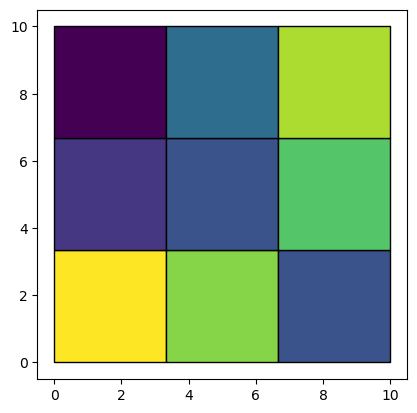

In [82]:

all_polys = pd.concat([p.to_gdf() for p in sub_polygons])
all_polys = all_polys.reset_index()
all_polys.plot('size', cmap='viridis', edgecolor='black')

In [44]:
poly.data["utils"] = False

In [46]:
poly.to_gdf()

,name,color,size,utils,geometry
0,square,red,1,False,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))"


In [40]:
all_shapes = pd.concat([line.to_gdf(), poly.to_gdf()], ignore_index=True)
all_shapes

,name,color,size,geometry
0,line,red,2,"LINESTRING (0 0, 1 1)"
1,square,red,1,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))"


In [28]:
poly.to_gdf()

,name,color,size,geometry
0,square,red,1,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))"


In [29]:
poly

Polygon(coords=[(0, 0), (1, 0), (1, 1), (0, 1)], data={'name': 'square', 'color': 'red', 'size': 1, 'geometry': <POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))>}, origin=(0, 0), size=(1, 1))

In [ ]:
class mPolygon(Vector):
    def __init__(
        self, 
        origin: Optional[Tuple[float, float]] = None,
        coords: Optional[List[Tuple[float, float]]] = None,
        size: Optional[Tuple[float, float]] = None,
        color: Optional[str] = 'blue',
        alpha: Optional[float] = 0.5,
        **kwargs
        ):
        

        if origin is not None and size is not None:
            self.coords = [
                origin,
                (origin[0] + size[0], origin[1]),
                (origin[0] + size[0], origin[1] + size[1]),
                (origin[0], origin[1] + size[1]),
            ]
        elif coords is not None:
            self.coords = coords
        else:
            raise ValueError("Must provide either `origin` and `size`, or `coords`.")
            
        self.geometry = Polygon(self.coords)
        self.color = color
        self.alpha = alpha

        for key, value in kwargs.items():
            setattr(self, key, value)


